# Introduction

The Crabtree effect is an anomaly that occurs in various microbes, including the yeast Saccharomyces cerevisiae. In baker's yeast, it is characterized by cells using both oxidative and substrate level phosphorilation simultaneously to generate energy, in spite of having excess O$_2$ at their disposal for full oxidative phosphorilation.

Von Meyerenburg (1969) did a study on this effect and his data is used as a base (or reference) case.

# Mathematics and theory

All relevant libraries and modules are imported:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import pandas as  pd
%matplotlib notebook

Certain physiological parameters are estimated:

In [2]:
alpha = 0.1
def beta(beta):
    nul1 = (1 + alpha)*4 - ((4 + 1*1.6 - 2*0.5 - 3*0.2) + 2*beta)
    return nul1
beta = fsolve(beta, alpha)[0]
MMX = 1*12 + 1.6*1 + 0.5*16 + 0.2*14
theta = 0
kLa = 200*60 # 1/h
cO2satmax = 7/1000/32  #mol/l
rO2mt = kLa*cO2satmax

The metabolic map of Saccharomyces cerevisiae is supplied below:

![Metabolism](Metabolism.png)

A black-box mass balance matrix is set up according to the reaction:
\begin{equation}
r_0 \times Glucose + r_1 \times NH_3 + r_2 \times O_2 + r_3 \times Biomass + r_4 \times Glycerol + r_5 \times Ethanol + r_6 \times CO_2 + r_7 \times H_2O
\end{equation}
and mathematically implemented below. Four specificaions are also set:
\begin{equation}
r_4 = 0
\end{equation}
\begin{equation}
r_3 = D_{exp}
\end{equation}
\begin{equation}
r_2 = r_{O_2 \ exp}
\end{equation}
\begin{equation}
r_6 = r_{CO_2 \ exp}
\end{equation}
The energy balance is described by:
\begin{equation}
r_{ATP} = 1/2*r_5 + 2 PO r_2 + 2/3(r_6 - 1/2r_5 - \alpha r_3)
\end{equation}
Functions are set up to solve for the P/O ratio, given a fixed $\gamma$ and for $\gamma$ given a fixed P/O ratio.

In [3]:
def POCalc(var):
    D, rCO2, rO2 = var
    gamma = 2.5
    POlys = []
    PO_init = 1.5
    for i in range(len(D)):
        S = np.matrix([[-1, 0, 0, 1, 1, 1, 1, 0],
                       [-2, -3, 0, 1.6, 8/3, 3, 0, 2],
                       [-1, 0, -2, 0.5, 1, 1/2, 2, 1],
                       [0, -1, 0, 0.2, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 1, 0]])
        C = np.array([0, 0, 0, 0, 0, D[i], rO2[i], rCO2[i]])
        r = np.linalg.solve(S, C)
        def PO_solve(var):
            POvar = var
            nul1 = 1/2*r[5] + 2*POvar*r[2] + 2/3*(r[6] - 1/2*r[5] - alpha*r[3]) - gamma*r[3]
            return nul1
        PO = fsolve(PO_solve, PO_init)
        POlys.append(PO)
    PO = np.array(POlys)
    return PO

In [4]:
def rATPCalc(var):
    D, rCO2, rO2 = var
    PO = 1.5
    gammalys = []
    for i in range(len(D)):
        S = np.matrix([[-1, 0, 0, 1, 1, 1, 1, 0],
                       [-2, -3, 0, 1.6, 8/3, 3, 0, 2],
                       [-1, 0, -2, 0.5, 1, 1/2, 2, 1],
                       [0, -1, 0, 0.2, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 1, 0]])
        C = np.array([0, 0, 0, 0, 0, D[i], rO2[i], rCO2[i]])
        r = np.linalg.solve(S, C)
        rATP = 1/2*r[5] + 2*PO*r[2] + 2/3*(r[6] - 1/2*r[5] - alpha*r[3])
        gamma = rATP/r[3]
        gammalys.append(gamma)
    gamma = np.array(gammalys)
    rATP = gamma*D#*1000/MMX
    return rATP

# Experimental

Data for dilution rate, $D$ ($1/h$) and mass based CO$_2$ and O$_2$ flow rates ($mmol/g \ X/h$) were obtained from a number of papers and combined into a single spreadsheet. These data were then imported via Pandas for each respective paper:

In [5]:
# Data manipulation

Data = pd.ExcelFile("Data.xlsx")
sheets = Data.sheet_names

Dlist, cXlist, rCO2list, rO2list = [], [], [], []
for j in sheets:
    df = pd.read_excel(Data, sheetname = str(j))
    m = df.as_matrix()
    cols = list(df.columns)
    D, cX, rCO2, rO2 = m[:,0], m[:,1], m[:,2], m[:,3]
    Dlist.append(D)
    cXlist.append(cX)
    rCO2list.append(rCO2)
    rO2list.append(rO2)
Ds, cXs, rCO2s, rO2s = np.array(Dlist), np.array(cXlist), np.array(rCO2list), np.array(rO2list)

# Results  and discussion

As mentioned previously, Von Meyerenburg (1969) is used as base case for discussion:

2.625
0.110218862756
[ 0.02898954  0.04956174  0.07046378  0.09169565  0.11021886  0.09556365
  0.07042539  0.05296886  0.04208988  0.03415646  0.02764868  0.02214571
  0.01759373  0.01385467  0.01053586  0.00710049]


<IPython.core.display.Javascript object>


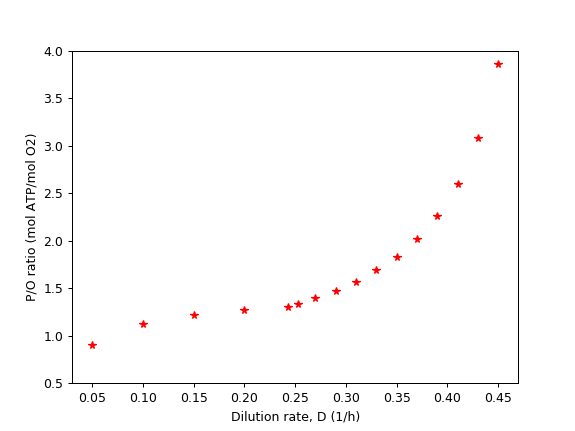

<IPython.core.display.Javascript object>


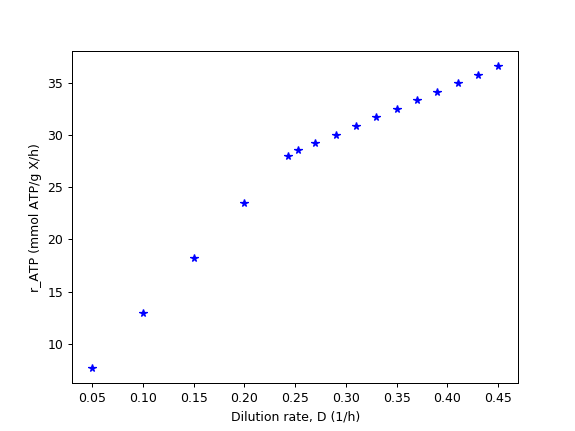

<IPython.core.display.Javascript object>


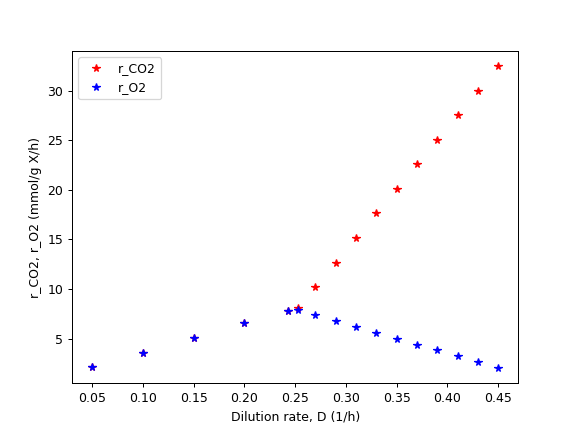

In [6]:
# Meyer69

name0 = sheets[0]
D0 = Ds[0]
cX0 = cXs[0]/MMX
rCO20 = rCO2s[0]/1000*MMX
rO20 = rO2s[0]/1000*MMX

print(rO2mt)
print(max(rO20*cX0))
print(rO20*cX0)

PO0 = POCalc([D0, rCO20, rO20])
plt.figure(name0 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 4])
plt.plot(D0, PO0, 'r*')
plt.show()

rATP0 = rATPCalc([D0, rCO20, rO20])*1000/MMX
plt.figure(name0 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D0, rATP0, 'b*')
plt.show()

plt.figure(name0 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D0, rCO20*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D0, rO20*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

The raw gas flow rate data is plotted against the dilution rate. It is noticible that at $D \ = \ 0.243$, a regime change occurs. This is the transition point where the yeast switches from a completely oxidative regime to an oxido-reductve regime. The CO$_2$ production rate suddenly increases, but the O$_2$ consumption rate appears to start decreasing.

When specifying a fixed $P/O \ ratio$ and calculating the mass based rate of ATP production ($r_{ATP}$), a decrease in the production slope occurs after the transition point.

When specifying a fixed $\gamma$ and calculating the $P/O \ ratio$, it starts off low (but is increasing), goes through an inflection and starts increasing exponentially.

Papers with similar results are Kock (2000):

<IPython.core.display.Javascript object>


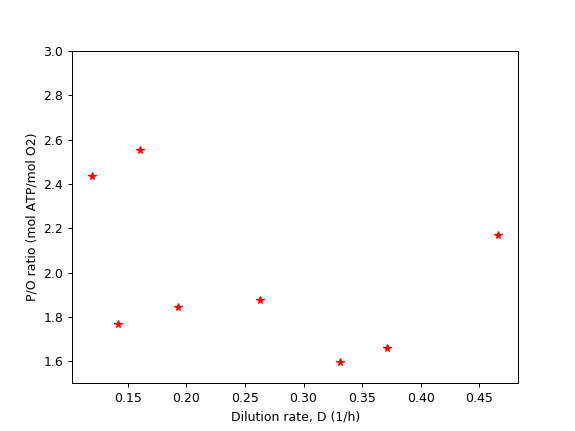

<IPython.core.display.Javascript object>


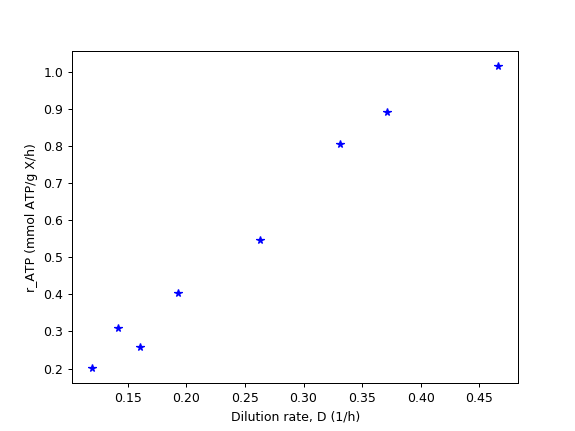

<IPython.core.display.Javascript object>


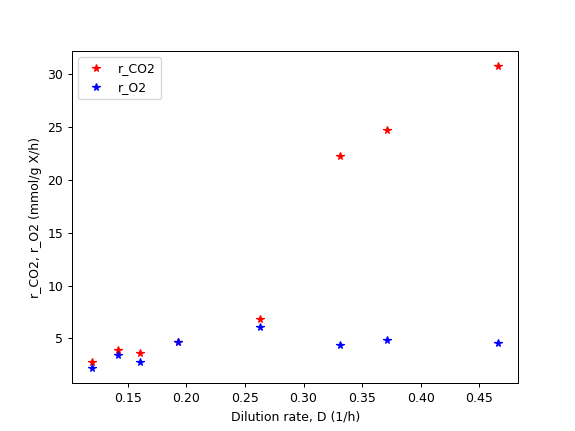

In [7]:
# Kock201

name4 = sheets[4]
D4 = Ds[4]
cX4 = cXs[4]/MMX
rCO24 = rCO2s[4]/1000*MMX
rO24 = rO2s[4]/1000*MMX

PO4 = POCalc([D4, rCO24, rO24])
plt.figure(name4 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([1.5, 3])
plt.plot(D4, PO4, 'r*')
plt.show()

rATP4 = rATPCalc([D4, rCO24, rO24])
plt.figure(name4 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D4, rATP4, 'b*')
plt.show()

plt.figure(name4 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D4, rCO24*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D4, rO24*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

<IPython.core.display.Javascript object>


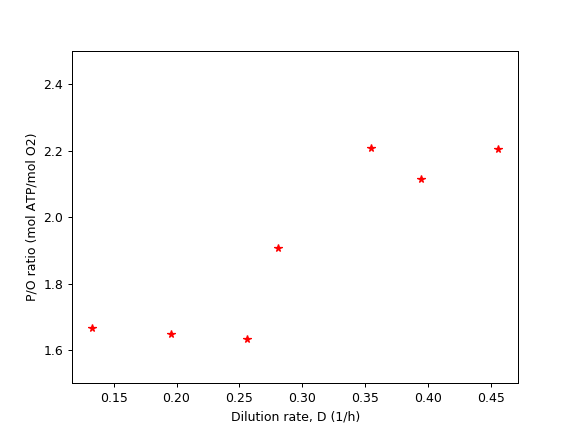

<IPython.core.display.Javascript object>


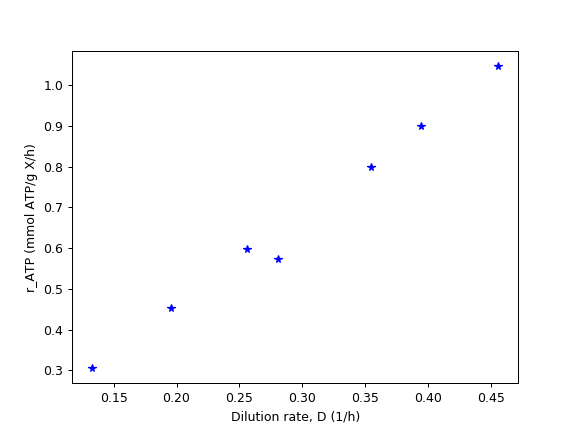

<IPython.core.display.Javascript object>


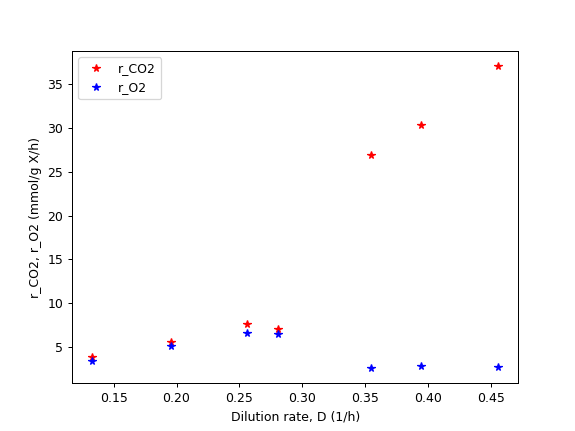

In [8]:
# Kock202

name5 = sheets[5]
D5 = Ds[5]
cX5 = cXs[5]/MMX
rCO25 = rCO2s[5]/1000*MMX
rO25 = rO2s[5]/1000*MMX

PO5 = POCalc([D5, rCO25, rO25])
plt.figure(name5 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([1.5, 2.5])
plt.plot(D5, PO5, 'r*')
plt.show()

rATP5 = rATPCalc([D5, rCO25, rO25])
plt.figure(name5 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D5, rATP5, 'b*')
plt.show()

plt.figure(name5 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D5, rCO25*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D5, rO25*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

and Van Hoek (1997):

<IPython.core.display.Javascript object>


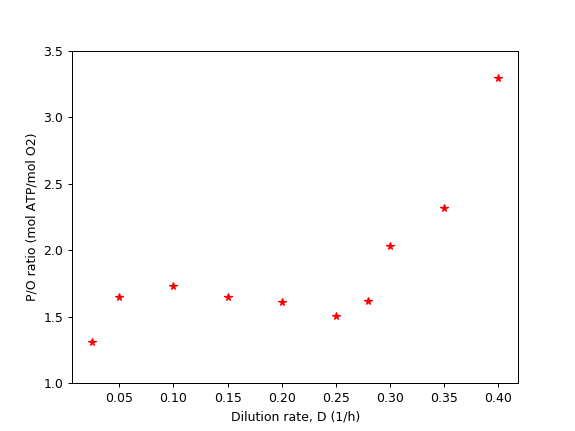

<IPython.core.display.Javascript object>


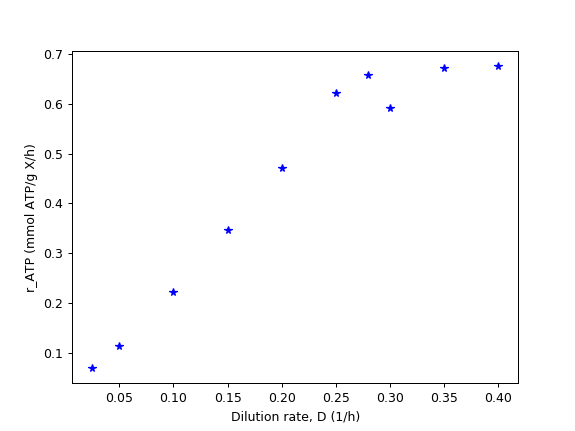

<IPython.core.display.Javascript object>


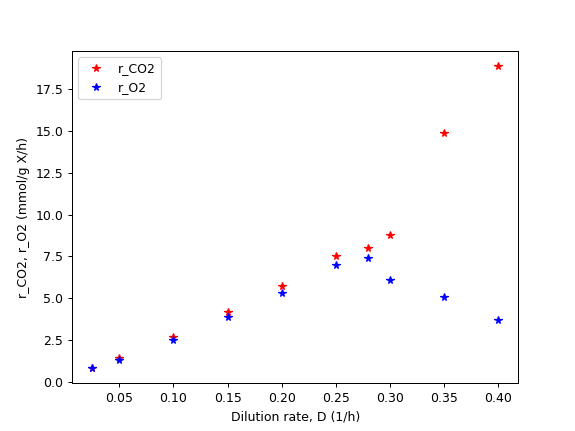

In [9]:
# VanHoek97

name7 = sheets[7]
D7 = Ds[7]
cX7 = cXs[7]/MMX
rCO27 = rCO2s[7]/1000*MMX
rO27 = rO2s[7]/1000*MMX

PO7 = POCalc([D7, rCO27, rO27])
plt.figure(name7 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([1, 3.5])
plt.plot(D7, PO7, 'r*')
plt.show()

rATP7 = rATPCalc([D7, rCO27, rO27])
plt.figure(name7 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D7, rATP7, 'b*')
plt.show()

plt.figure(name7 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D7, rCO27*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D7, rO27*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

Barford (1979), however, rejects the data obtained by Von Meyerenburg (1969).

There is a percieved decrease in oxygen consumption in the above papers. Barford (1979), however, notes that they did not obtain similar results but instead, the oxygen consumption rate  stayed constant after the transition point. When examining the Von Meyerenburg (1969) methodology more closely, it was discovered that while the reactor setup was allowed to achieve steady state, the yeast cells did not yet achieve "steady state".

Von Meyerenburg (1969) used shaker flasks (a batch setup) as inoculum preparation for their chemostat runs. In these batch setups, the cultures experienced respiratory repression due to restricted aeration in the flasks. When these cultures are then added to a chemostat, it takes a considerable amount of time for them to adapt to fully respiratory conditions.

Barford (1979) found that, given enough time, the chemostat cultures fully adapted and no respiration repression was observed for either glucose or galactose as substrate. Respiration of all cultures saturated at $D \ = 0.31 \ 1/h$.

Results from Barford (1979) are presented below:

2.625
0.0330004664411
[ 0.0090874   0.01855649  0.02729143  0.03177183  0.03280115  0.03300047
  0.02722539  0.02105196  0.01940793  0.01874067]


<IPython.core.display.Javascript object>


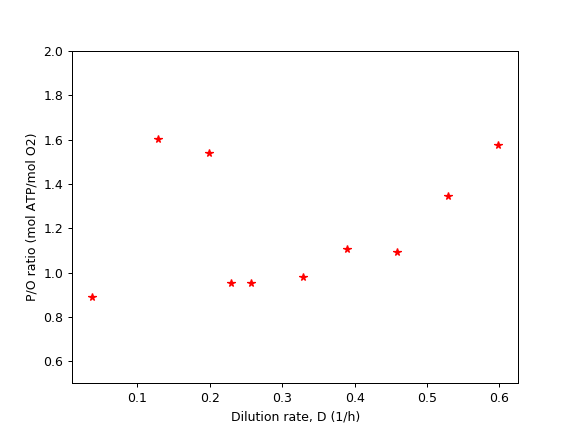

<IPython.core.display.Javascript object>


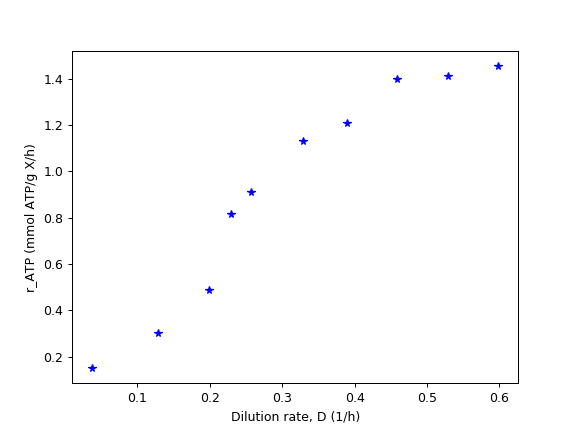

<IPython.core.display.Javascript object>


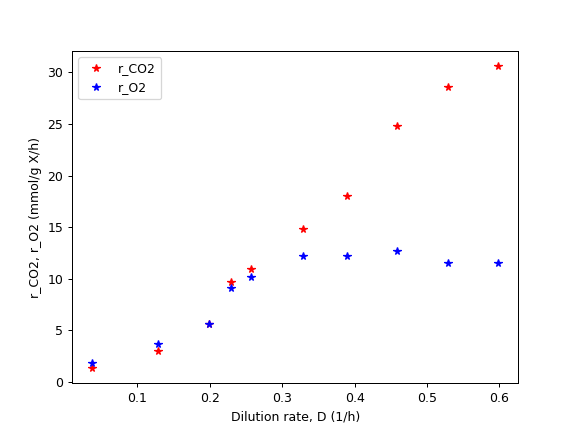

In [10]:
# Barford79

name1 = sheets[1]
D1 = Ds[1]
cX1 = cXs[1]/MMX
rCO21 = rCO2s[1]/1000*MMX
rO21 = rO2s[1]/1000*MMX

print(rO2mt)
print(max(rO21*cX1))
print(rO21*cX1)

PO1 = POCalc([D1, rCO21, rO21])
plt.figure(name1 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 2])
plt.plot(D1, PO1, 'r*')
plt.show()

rATP1 = rATPCalc([D1, rCO21, rO21])
plt.figure(name1 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D1, rATP1, 'b*')
plt.show()

plt.figure(name1 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D1, rCO21*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D1, rO21*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

Papers with similar results are Cortassa (1998):

<IPython.core.display.Javascript object>


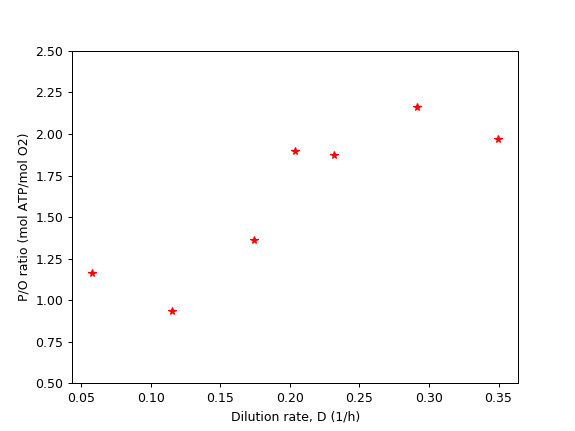

<IPython.core.display.Javascript object>


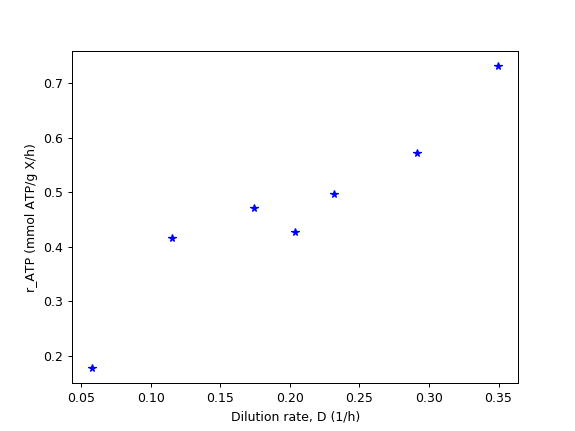

<IPython.core.display.Javascript object>


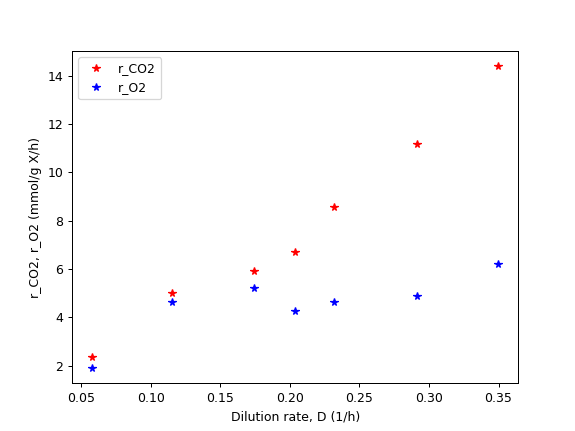

In [11]:
# Cortassa98

name6 = sheets[6]
D6 = Ds[6]
cX6 = cXs[6]/MMX
rCO26 = rCO2s[6]/1000*MMX
rO26 = rO2s[6]/1000*MMX

PO6 = POCalc([D6, rCO26, rO26])
plt.figure(name6 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 2.5])
plt.plot(D6, PO6, 'r*')
plt.show()

rATP6 = rATPCalc([D6, rCO26, rO26])
plt.figure(name6 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D6, rATP6, 'b*')
plt.show()

plt.figure(name6 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D6, rCO26*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D6, rO26*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

Both Barford (1979) and Cortassa (1998) show an increase in $P/O \ ratio$ as $D$ increases. Both also retain a linearly increasing $r_{ATP}$. Both have a constant mass based oxygen consumption rate after the transition point.

Papers with a constant oxygen consumption rate, but a decreasing $P/O \ ratio$ and increasing $r_{ATP}$ after the transition point were also found. They provide the same results as Barford (1979) concerning a constant oxygen consumption rate, but differ with regards to $P/O \ ratio$ and $r_{ATP}$.

The most prominent example of this is Postma (1989):

2.625
0.212133372653
[ 0.02144634  0.04769457  0.07428099  0.10191594  0.12654696  0.13015974
  0.14384422  0.18238099  0.18940498  0.18375159  0.21213337  0.10362686
  0.08972336  0.08175873  0.07364791  0.06655147  0.06698811  0.0681941
  0.07152234  0.07287737]


<IPython.core.display.Javascript object>


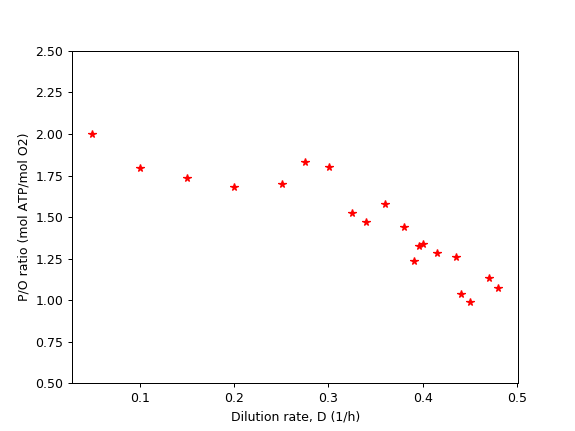

<IPython.core.display.Javascript object>


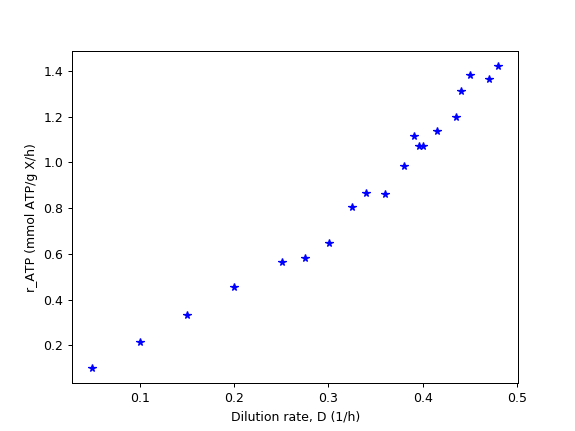

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


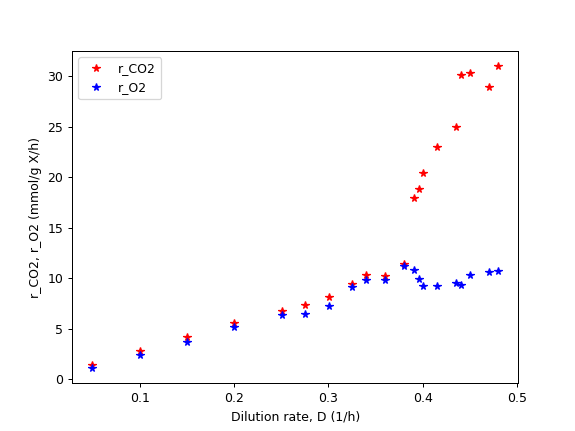

In [12]:
# Postma89

name8 = sheets[8]
D8 = Ds[8]
cX8 = cXs[8]/MMX
rCO28 = rCO2s[8]/1000*MMX
rO28 = rO2s[8]/1000*MMX

print(rO2mt)
print(max(rO28*cX8))
print(rO28*cX8)

PO8 = POCalc([D8, rCO28, rO28])
plt.figure(name8 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 2.5])
plt.plot(D8, PO8, 'r*')
plt.show()

rATP8 = rATPCalc([D8, rCO28, rO28])
plt.figure(name8 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D8, rATP8, 'b*')
plt.show()

plt.figure(name8 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D8, rCO28*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D8, rO28*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

but similar results are also seen from Rieger (1983):

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


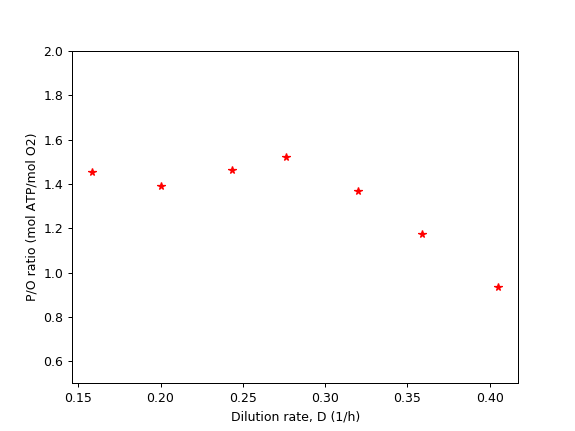

<IPython.core.display.Javascript object>


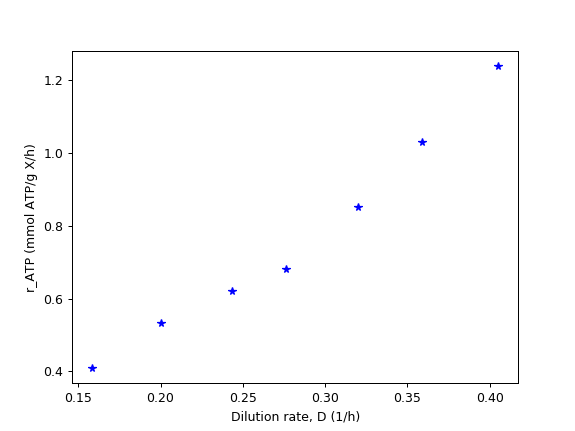

<IPython.core.display.Javascript object>


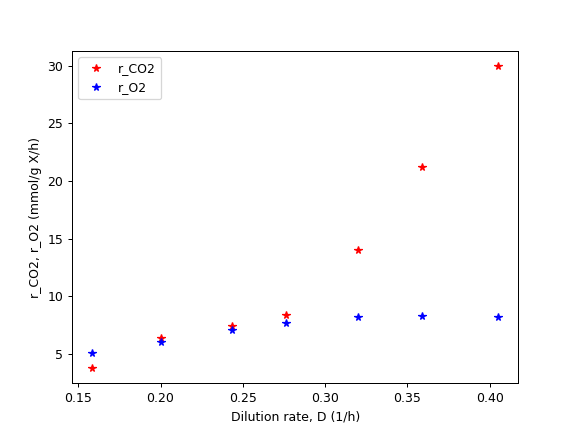

In [13]:
# Rieger83

name3 = sheets[3]
D3 = Ds[3]
cX3 = cXs[3]/MMX
rCO23 = rCO2s[3]/1000*MMX
rO23 = rO2s[3]/1000*MMX

PO3 = POCalc([D3, rCO23, rO23])
plt.figure(name3 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 2])
plt.plot(D3, PO3, 'r*')
plt.show()

rATP3 = rATPCalc([D3, rCO23, rO23])
plt.figure(name3 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D3, rATP3, 'b*')
plt.show()

plt.figure(name3 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D3, rCO23*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D3, rO23*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

and Sonnleitner (1986):

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


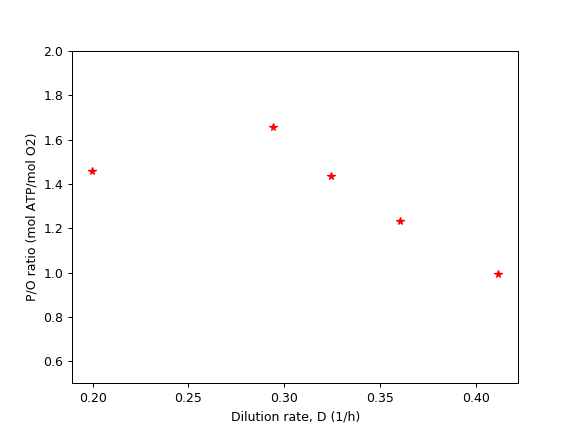

<IPython.core.display.Javascript object>


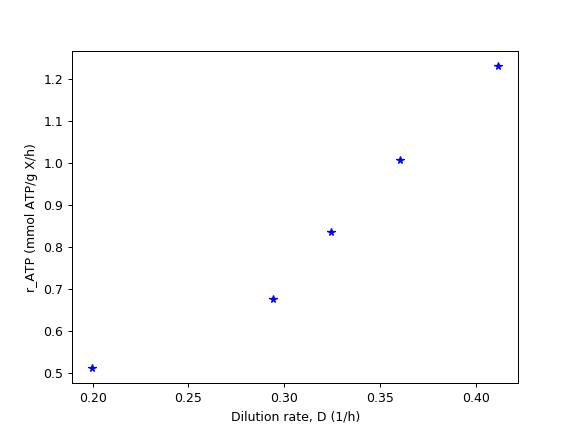

<IPython.core.display.Javascript object>


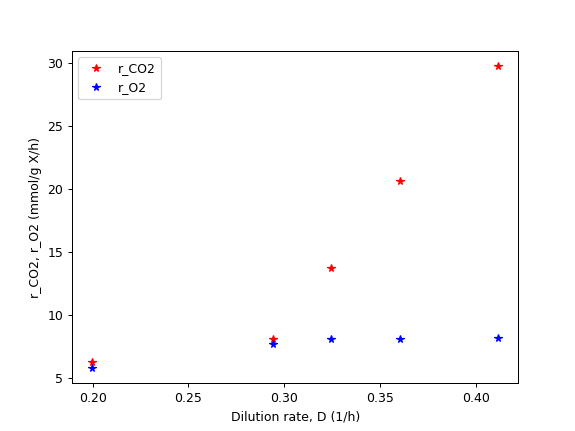

In [14]:
# Sonn86

name10 = sheets[10]
D10 = Ds[10]
cX10 = cXs[10]/MMX
rCO210 = rCO2s[10]/1000*MMX
rO210 = rO2s[10]/1000*MMX

PO10 = POCalc([D10, rCO210, rO210])
plt.figure(name10 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 2])
plt.plot(D10, PO10, 'r*')
plt.show()

rATP10 = rATPCalc([D10, rCO210, rO210])
plt.figure(name10 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D10, rATP10, 'b*')
plt.show()

plt.figure(name10 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D10, rCO210*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D10, rO210*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()

Barford (1979) was correct in all likelyhood when pointing out the differences between his own and the Von Meyerenburg (1969) data. It also seems, however, that Barford (1979) then also fell into this trap of not allowing for enough time for the yeast to adapt fully to aerobic conditions.

If the yeast cells are utilizing the available oxygen to the full extent of their ability, then their respiration efficiency, $P/O \ ratio$, would remain constant on a biomass basis before the transition point and then decrease after the transition point (as the ATP consumption rate, $r_{ATP}$, increases). This is the case with the Postma (1989), Rieger (1983) and Sonnleitner (1986) data, grouped as the third category of data.

What we see in the second category is that, even though $r_{ATP}$ increases after the transition point, the $P/O \ ratio$ also increases, which would be impossible (given the currently available data) except if the yeast is still adjusting to its new conditions, meaning that the cells have indeed not yet adapted to fully respiratory conditions.

# Conclusion

The data, from papers gathered on the Crabtree effect in Saccharomyces cerevisiae, may be divided into three categories:
* Von Meyerenburg (1969), Kock (2000), Van Hoek (1997): Cells completely unadapted to the aerobic chemostat environment.
* Barford (1979), Cortassa (1998): Cells somewhat adapted to the aerobic chemostat environment, undetectable without performing an energy balance.
* Postma (1989), Rieger (1983), Sonnleitner (1986): Cells fully adapter to the aerobic chemostat environment, providing trustworthy results and leading to accurate conclusions.

# Additional observations

The volumetric oxygen mass transfer rate was obtained from one paper out of each category, as not all authors provided the biomass concentrations, to determine if any experiments were conducted under oxygen limited conditions. Von Meyerenburg (1969), Barford (1979) and Postma (1989) were tested. The maximum oxygen mass transfer rate was determined at a stirrer speed of $200 \ rpm$. The lowest stirrer speed experimentally used was $700 \ rpm$. The results obtained are as follows:

In [15]:
kLa = 200*60 # 1/h
cO2satmax = 7/1000/32  #mol/l
rO2mt = kLa*cO2satmax
print('Maximum oxygen mass transfer rate: ' + str(rO2mt) + ' mol O_2/l/h')
print('Category one highest oxygen mass transfer rate: ' + str(max(rO20*cX0)) + ' mol O_2/l/h')
print('Category two highest oxygen mass transfer rate: ' + str(max(rO21*cX1)) + ' mol O_2/l/h')
print('Category three highest oxygen mass transfer rate: ' + str(max(rO28*cX8)) + ' mol O_2/l/h')

Maximum oxygen mass transfer rate: 2.625 mol O_2/l/h
Category one highest oxygen mass transfer rate: 0.110218862756 mol O_2/l/h
Category two highest oxygen mass transfer rate: 0.0330004664411 mol O_2/l/h
Category three highest oxygen mass transfer rate: 0.212133372653 mol O_2/l/h


It may be concluded that all experiments were conducted well within acceptable oxygen mass transfer rates.

The biomass concentrations obtained from the above three papers are also shown below:

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


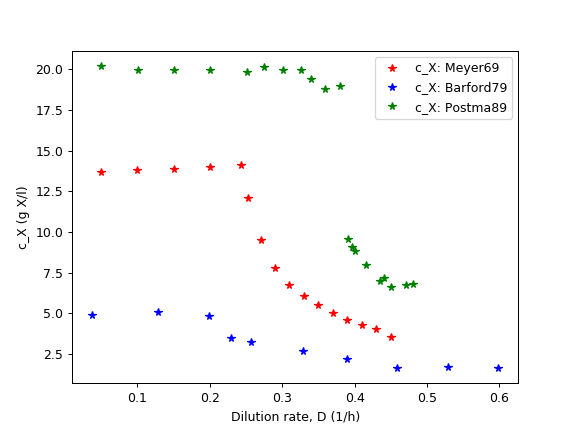

In [16]:
plt.figure(str('Biomass Concentrations'))
plt.ylabel("c_X (g X/l)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D0, cX0*MMX, 'r*', label = 'c_X: ' + name0)
plt.plot(D1, cX1*MMX, 'b*', label = 'c_X: ' + name1)
plt.plot(D8, cX8*MMX, 'g*', label = 'c_X: ' + name8)
plt.legend(loc = 'best')
plt.show()

# Appendix

Data from Hall (1979) and Pejin (1993) were also obtained, but proved not to be much help as these were either too inaccurate (scattered) or did not make sense ($r_{O_2} \ > \ r_{CO_2}$). They are provided below:

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


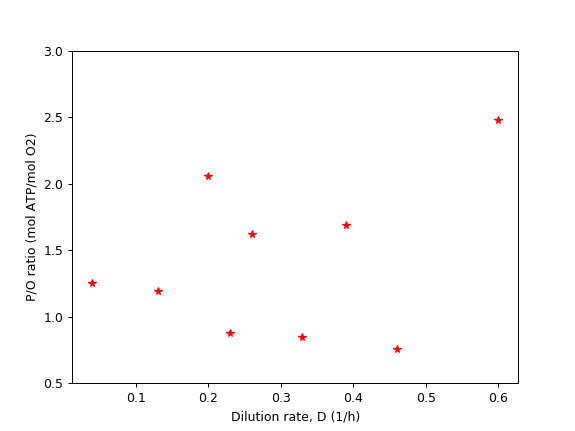

<IPython.core.display.Javascript object>


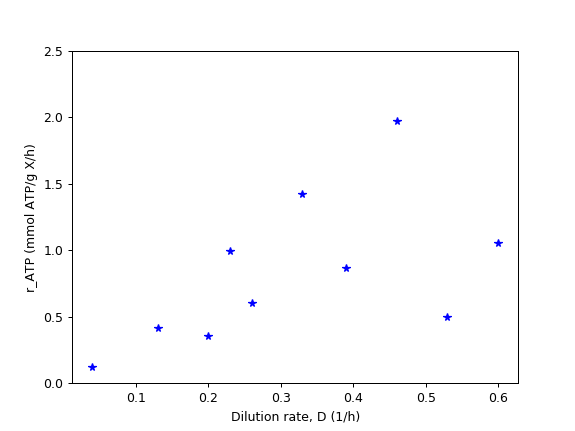

<IPython.core.display.Javascript object>


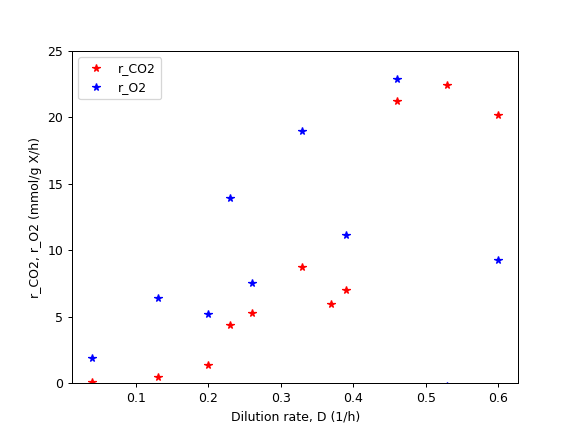

In [17]:
# Hall79

name2 = sheets[2]
D2 = Ds[2]
cX2 = cXs[2]/MMX
rCO22 = rCO2s[2]/1000*MMX
rO22 = rO2s[2]/1000*MMX

PO2 = POCalc([D2, rCO22, rO22])
plt.figure(name2 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0.5, 3])
plt.plot(D2, PO2, 'r*')
plt.show()

rATP2 = rATPCalc([D2, rCO22, rO22])
plt.figure(name2 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D2, rATP2, 'b*')
plt.ylim([0, 2.5])
plt.show()

plt.figure(name2 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D2, rCO22*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D2, rO22*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.ylim([0, 25])
plt.show()

C:\Users\NW de Jongh\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


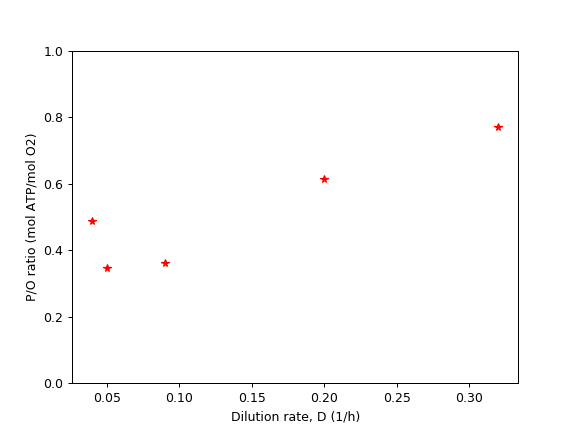

<IPython.core.display.Javascript object>


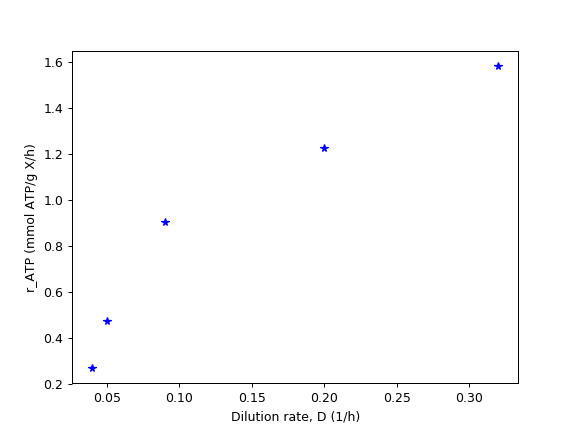

<IPython.core.display.Javascript object>


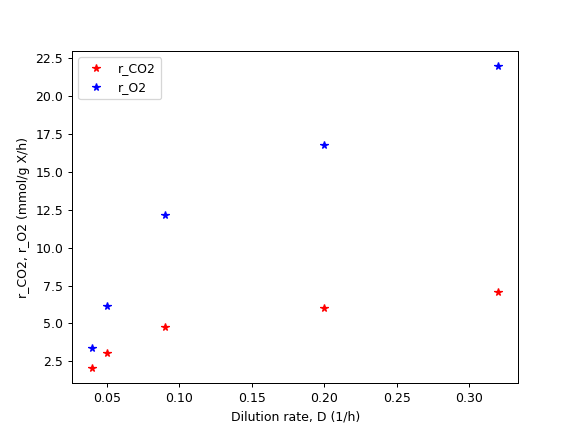

In [18]:
# Pijen93

name9 = sheets[9]
D9 = Ds[9]
cX9 = cXs[9]/MMX
rCO29 = rCO2s[9]/1000*MMX
rO29 = rO2s[9]/1000*MMX

PO9 = POCalc([D9, rCO29, rO29])
plt.figure(name9 + str(' Energy Efficiency'))
plt.ylabel("P/O ratio (mol ATP/mol O2)")
plt.xlabel("Dilution rate, D (1/h)")
plt.ylim([0, 1])
plt.plot(D9, PO9, 'r*')
plt.show()

rATP9 = rATPCalc([D9, rCO29, rO29])
plt.figure(name9 + str(' ATP Generation'))
plt.ylabel("r_ATP (mmol ATP/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D9, rATP9, 'b*')
plt.show()

plt.figure(name9 + str(' Gas Rates'))
plt.ylabel("r_CO2, r_O2 (mmol/g X/h)")
plt.xlabel("Dilution rate, D (1/h)")
plt.plot(D9, rCO29*1000/MMX, 'r*', label = 'r_CO2')
plt.plot(D9, rO29*1000/MMX, 'b*', label = 'r_O2')
plt.legend(loc = 'best')
plt.show()